In [16]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

# Define the paths to your image and annotation folders
path_image = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/image"
path_annotations = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/annotation"

# Initialize lists to store images and masks
images = []
masks = []

# Initialize counters for the classes
apal_count = 0
pseudodiploria_count = 0

# Set the desired balance ratio
desired_balance_ratio = 0.5  # 50% APAL, 50% Pseudodiploria

# Iterate through each image file in the image folder
for image_filename in os.listdir(path_image):
    if image_filename.lower().endswith(".jpg"):  # Check for image files
        image_path = os.path.join(path_image, image_filename)

        # Load the image using OpenCV
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is not None:
            # Resize the image to 224x224 if needed
            if image.shape[0] >= 224 and image.shape[1] >= 224:
                image = cv2.resize(image, (224, 224))
            else:
                print(f"Image dimensions are too small for resizing: {image_path}")

            # Load the corresponding XML label
            xml_filename = os.path.splitext(image_filename)[0] + ".xml"
            xml_path = os.path.join(path_annotations, xml_filename)

            # Check if the XML file exists
            if os.path.exists(xml_path):
                # Parse the XML file to extract the label and generate the mask
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Initialize a binary mask for this image
                mask = np.zeros(image.shape[:2], dtype=np.uint8)

                for obj in root.findall("object"):
                    name_element = obj.find("name")
                    if name_element is not None:
                        label = name_element.text
                        # Assuming label is the name of the coral class
                        # Find the polygon points and draw the mask
                        polygon = obj.find("polygon")
                        if polygon is not None:
                            points = []
                            for pt in polygon.findall("pt"):
                                x = int(pt.find("x").text)
                                y = int(pt.find("y").text)
                                points.append((x, y))
                            points = np.array(points, dtype=np.int32)
                            cv2.fillPoly(mask, [points], 1)

                # Check the class label and balance the dataset
                if label == "APAL":
                    apal_count += 1
                elif label == "Pseudodiploria":
                    pseudodiploria_count += 1

                # Append the image and mask to the lists
                images.append(image)
                masks.append(mask)

                # If the APAL class count is below the desired balance ratio, add more samples
                if apal_count / (apal_count + pseudodiploria_count) < desired_balance_ratio:
                    images.append(image)
                    masks.append(mask)

            else:
                # Handle the case where the XML label file is missing
                print(f"XML label file not found for image: {image_path}")

# Convert the lists to NumPy arrays
images = np.array(images)
masks = np.array(masks)

# Now, check the shapes
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")


Images shape: (1798, 224, 224, 3)
Masks shape: (1798, 224, 224)


Coral Type: Pseudodiploria


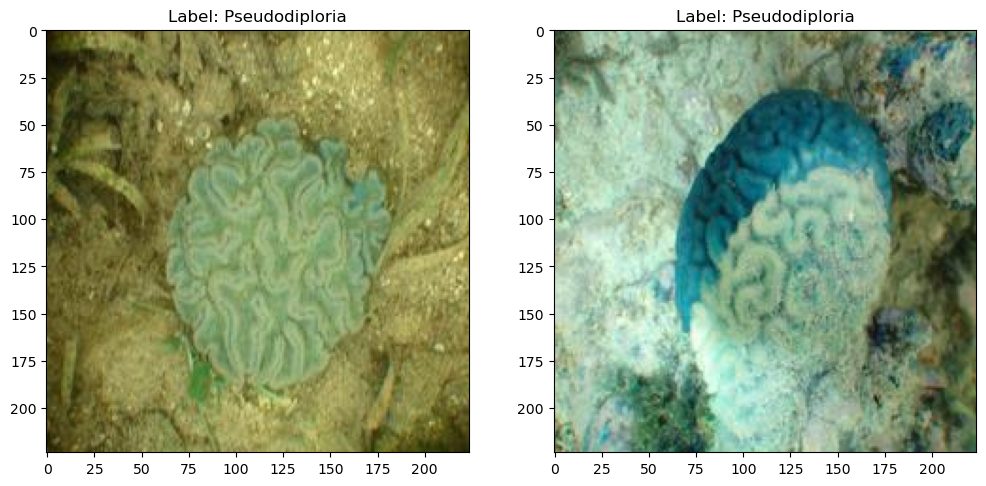

Coral Type: APAL


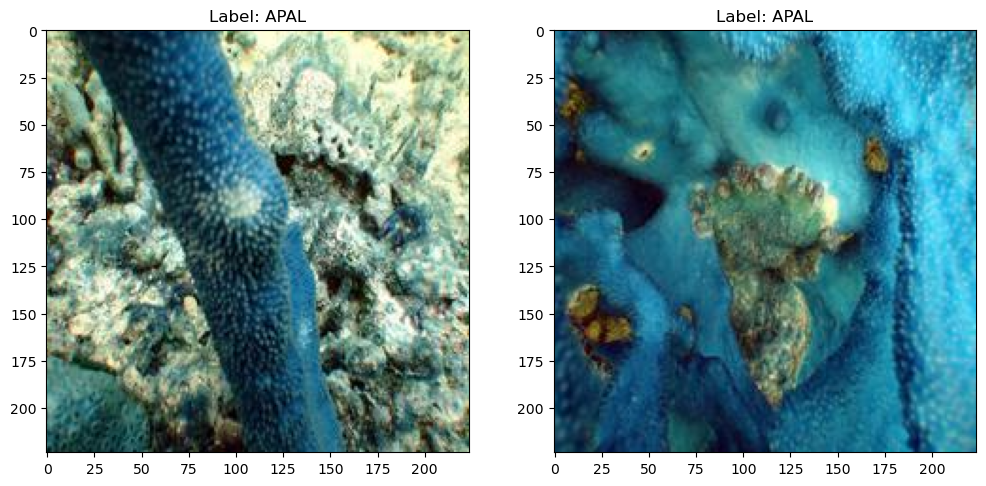

In [14]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import random
import matplotlib.pyplot as plt

# Define the paths to your image and annotation folders
path_image = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/image"
path_annotations = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/annotation"

# Initialize dictionaries to store images and masks by type
image_dict = {}
mask_dict = {}

# Iterate through each image file in the image folder
for image_filename in os.listdir(path_image):
    if image_filename.lower().endswith(".jpg"):  # Check for image files
        image_path = os.path.join(path_image, image_filename)

        # Load the image using OpenCV
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is not None:
            # Resize the image to 224x224 if needed
            if image.shape[0] >= 224 and image.shape[1] >= 224:
                image = cv2.resize(image, (224, 224))
            else:
                print(f"Image dimensions are too small for resizing: {image_path}")

            # Load the corresponding XML label
            xml_filename = os.path.splitext(image_filename)[0] + ".xml"
            xml_path = os.path.join(path_annotations, xml_filename)

            # Check if the XML file exists
            if os.path.exists(xml_path):
                # Parse the XML file to extract the label and generate the mask
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Initialize a binary mask for this image
                mask = np.zeros(image.shape[:2], dtype=np.uint8)

                for obj in root.findall("object"):
                    name_element = obj.find("name")
                    if name_element is not None:
                        label = name_element.text
                        # Assuming label is the name of the coral class
                        # Find the polygon points and draw the mask
                        polygon = obj.find("polygon")
                        if polygon is not None:
                            points = []
                            for pt in polygon.findall("pt"):
                                x = int(pt.find("x").text)
                                y = int(pt.find("y").text)
                                points.append((x, y))
                            points = np.array(points, dtype=np.int32)
                            cv2.fillPoly(mask, [points], 1)

                # Organize images and masks by label
                if label in image_dict:
                    image_dict[label].append(image)
                    mask_dict[label].append(mask)
                else:
                    image_dict[label] = [image]
                    mask_dict[label] = [mask]
            else:
                # Handle the case where the XML label file is missing
                print(f"XML label file not found for image: {image_path}")

# Display two images from each type with their labels in subplots
for label, images in image_dict.items():
    if len(images) >= 2:
        print(f"Coral Type: {label}")
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        for i in range(2):
            axes[i].imshow(images[i])
            axes[i].set_title(f"Label: {label}")
        plt.show()


In [19]:
from sklearn.model_selection import train_test_split
import pickle

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Save your data to a pickle file
with open('../data/external/data_RCNN.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test), f)

# Check the shapes
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (1438, 224, 224, 3)
y_train shape: (1438, 224, 224)
X_test shape: (360, 224, 224, 3)
y_test shape: (360, 224, 224)
